# 1. Define binning and model

In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
cabinetry.set_logging()

In [3]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.5 # 0.8 before adding fakeD
end = 4.2
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -3 # -1.1 before adding fakeD
end = 9.5 # 8.6 before adding fakeD
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

# Define the minimum bin counts
bin_threshold = 1


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables
template_with_FakeD=False

In [4]:
sample_lists = ['subset_0.root:B0',
                         'subset_1.root:B0',
                         'subset_2.root:B0',
#                          'subset_3.root:B0',
#                          'subset_4.root:B0',
#                          'subset_5.root:B0',
#                          'subset_6.root:B0',
#                          'subset_7.root:B0',
#                          'subset_8.root:B0',
]


if template_with_FakeD:
    input_cut = '((5<=mode) & (mode<=15)) | (mode==0)'
else:
    input_cut = '(5<=mode) & (mode<=15)'

columns = util.all_relevant_variables


# Load template samples
temp = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/{f}' for f in sample_lists],
                          library="np",
                          cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_temp = pd.DataFrame(temp)
        # df_temp['__weight__'] = self.weight_template # weight = 2 * bootstrap_fraction
        
            

#################### Classify template samples  ##################
DecayMode = {'bkg_fakeD':0,           'bkg_continuum':1,    'bkg_combinatorial':2,
             'bkg_Odecay':3,          'bkg_fakeTC':4,       r'$D\tau\nu$':5,
             r'$D^\ast\tau\nu$':6,    r'$D\ell\nu$':7,      r'$D^\ast\ell\nu$':8,
             r'$D^{\ast\ast}\tau\nu$':[9,10],               r'res_$D^{\ast\ast}\ell\nu$':[11,14],
             r'gap_non_$D^{\ast\ast}\ell\nu$':[12,13,15],   'bkg_others':16}

templates = {}

for name, mode in DecayMode.items():
    if type(DecayMode[name])==int:
        sample = df_temp.query(f'mode=={DecayMode[name]}')
        if len(sample)==0:
            continue
        else:
            templates[name] = sample
    elif type(DecayMode[name])==list:
        nModes = len(DecayMode[name])
        query_string = f'mode=={DecayMode[name][0]}'
        for i in range(nModes):
            if i==0:
                continue
            else:
                query_string += f' or mode=={DecayMode[name][i]}'
        sample = df_temp.query(query_string)
        if len(sample)==0:
            continue
        else:
            templates[name] = sample
    else:
        raise TypeError('Error: mode has to be an int or a list')


#################### Create template 2d histograms ################


t_histograms = {}
t_staterr = {}
for name, df in templates.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    t_histograms[name] = counts.T
    t_staterr[name] = np.sqrt(staterr_squared).T



################### Trimming and flattening ###############
# remove bins with count smaller than bin_threshold
indices_threshold = np.where(np.sum(list(t_histograms.values()),axis=0) >= bin_threshold)
template_flat = {name:t[indices_threshold].tolist() for name,t in t_histograms.items()}
staterr_flat = {name:se[indices_threshold].tolist() for name,se in t_staterr.items()}


In [5]:
asimov_data = np.sum(list(template_flat.values()),axis=0)

In [5]:
df = pd.DataFrame(temp)

#df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)
df['D_daughter_pValue_min'] = df[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].min(axis=1)
df['D_daughter_pValue_mean'] = df[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].mean(axis=1)

# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

In [6]:
# signal region
cut_signal = 'signal_prob==largest_prob and signal_prob>0.8 and \
D_daughter_pValue_min>D_daughter_pValue_mean/100'
df_lgb=df_lgb.query(cut_signal)

cut_sr='1.855<D_M<1.885'

# apply the mva cut
df_cut_sr=df_lgb.query(cut_sr)
df_bestSelected_sr=df_cut_sr.loc[df_cut_sr.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df_sr, samples_sr=util.get_dataframe_samples(df_bestSelected_sr, 'e', template=True)
# mpl=util.mpl(samples)
# ply=util.ply(df)

# construct templates and test data
templates_sr = {}
test_sr = []
for name in [r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D\ell\nu$',r'$D^\ast\ell\nu$']:
    templates_sr[name] = samples_sr[name].sample(frac=0.6, random_state=0)
    test_sr.append(pd.concat([samples_sr[name], templates_sr[name]]).drop_duplicates(keep=False))

# D** tau nu
Dstst_tau_sr = pd.concat([samples_sr[r'$D^{\ast\ast}\tau\nu$_mixed'],samples_sr[r'$D^{\ast\ast}\tau\nu$_charged']])
templates_sr[r'$D^{\ast\ast}\tau\nu$'] = Dstst_tau_sr.sample(frac=0.6, random_state=0)
test_sr.append(pd.concat([Dstst_tau_sr, templates_sr[r'$D^{\ast\ast}\tau\nu$']]).drop_duplicates(keep=False))

# D** ell nu resonants
Dstst_l_res_sr = pd.concat([samples_sr[r'res_$D^{\ast\ast}\ell\nu$_mixed'],samples_sr[r'res_$D^{\ast\ast}\ell\nu$_charged']])
templates_sr[r'res_$D^{\ast\ast}\ell\nu$'] = Dstst_l_res_sr.sample(frac=0.6, random_state=0)
test_sr.append(pd.concat([Dstst_l_res_sr, templates_sr[r'res_$D^{\ast\ast}\ell\nu$']]).drop_duplicates(keep=False))

# D** ell nu non-res
Dstst_l_non_sr = pd.concat([samples_sr[r'nonres_$D^{\ast\ast}\ell\nu$_mixed'],
                         samples_sr[r'nonres_$D^{\ast\ast}\ell\nu$_charged'],])
Dstst_l_non_temp_sr = Dstst_l_non_sr.sample(frac=0.6, random_state=0)
Dstst_l_non_test_sr = pd.concat([Dstst_l_non_sr, Dstst_l_non_temp_sr]).drop_duplicates(keep=False)
test_sr.append(Dstst_l_non_test_sr)

# special treatment for the gap modes
Dstst_gap_temp_sr = samples_sr[r'gap_$D^{\ast\ast}\ell\nu$_mixed'].sample(frac=0.6, random_state=0)
Dstst_gap_test_sr = pd.concat([Dstst_gap_temp_sr, samples_sr[r'gap_$D^{\ast\ast}\ell\nu$_mixed']]).drop_duplicates(keep=False)
Dstst_gap_test_sr['__weight__'] = 1
test_sr.append(Dstst_gap_test_sr)

templates_sr[r'non_gap_$D^{\ast\ast}\ell\nu$'] = pd.concat([Dstst_l_non_temp_sr,Dstst_gap_temp_sr])

# Fake D
# fakeD_temp_sr = samples_sr['bkg_fakeD'].sample(frac=0.6, random_state=0)
# fakeD_test_sr = pd.concat([fakeD_temp_sr, samples_sr[r'bkg_fakeD']]).drop_duplicates(keep=False)
# templates_sr['bkg_fakeD'] = fakeD_temp_sr
# test_sr.append(fakeD_test_sr)

data_sr = pd.concat(test_sr)

for name, df in templates_sr.items():
    df['__weight__'] = 2/3
    print(name, len(df))

$D\tau\nu$ 3935
$D^\ast\tau\nu$ 1996
$D\ell\nu$ 38813
$D^\ast\ell\nu$ 25198
$D^{\ast\ast}\tau\nu$ 1199
res_$D^{\ast\ast}\ell\nu$ 23350
non_gap_$D^{\ast\ast}\ell\nu$ 4876


In [7]:
# Create template histograms
t_histograms_sr = {}
t_staterr_sr = {}
for name, template in templates_sr.items():
    
    (counts_sr, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__'])
    
    (staterr_squared_sr, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__']**2)
    t_staterr_sr[name] = np.sqrt(staterr_squared_sr).T
    t_histograms_sr[name] = counts_sr.T
    
# Create data histogram
(d_histogram_sr, xedges, yedges) = np.histogram2d(data_sr['B0_CMS3_weMissM2'], 
                                               data_sr['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins],
                                               weights=data_sr['__weight__'])
d_histogram_sr = d_histogram_sr.T
    
indices_threshold_sr = np.where(np.sum(list(t_histograms_sr.values()),axis=0) >= bin_threshold)
template_flat_sr = {name:list(t[indices_threshold_sr]) for name,t in t_histograms_sr.items()}
staterr_flat_sr = {name:list(se[indices_threshold_sr]) for name,se in t_staterr_sr.items()}
# data = counts.ravel().to_list()
data_flat_sr = list(d_histogram_sr[indices_threshold_sr])

# edges = np.linspace(0, len(data), len(data)+1)
# truth = np.array([int(np.sum(t0)) for t0 in test0])


# 2. Create a pyhf workspace

In [6]:
workspace_path = "R_D_2d_workspace_noFakeD.json"
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        0.0,
                        1.3333333333333333,
                        0.6666666666666666,
                        0.6666666666666666,
                        1.3333333333333333,
                        0.6666666666666666,
                        0.0,
                        0.0,
                        0.6666666666666666,
                        0.0,
                        0.0,
                        1.3333333333333333,
                        0.6666666666666666,
                        0.0,
                        0.0,
                        0.0,
                        3.333333333333333,
                        1.3333333333333333,
                        2.0,
                        1.3333333333333333,
                        0.6666666666666666,
                        0.0,
                        1.3333333333333333,

In [8]:
# update templates and data in the workspace
# signal region
names = list(template_flat.keys())
for i, sample_SignalRegion in enumerate(spec['channels'][0]['samples']):
    sample_SignalRegion['name'] = names[i]
    sample_SignalRegion['data'] = template_flat[names[i]]
    for m in sample_SignalRegion['modifiers']:
        if m['type']=='staterror':
            m['data'] = staterr_flat[names[i]]
            m['name'] = 'staterror_signal_region'
        if m['type']=="normfactor":
            m['name'] = names[i]+'_norm'

# D sideband
# for i in [1,2]:
#     Dsideband = spec['channels'][i]['samples'][0]
#     if i==1:
#         Dsideband['data']=template_flat_Dlsb['bkg_fakeD']
#         Dsideband['name']='D_sideband_Left'
#     else:
#         Dsideband['data']=template_flat_Drsb['bkg_fakeD']
#         Dsideband['name']='D_sideband_Right'
#     for m in Dsideband['modifiers']:
#         if m['type']=='staterror' and i==1:
#             m['data'] = staterr_flat_Dlsb['bkg_fakeD']
#             m['name'] = 'staterror_Dsideband_Left'
#         if m['type']=='staterror' and i==2:
#             m['data'] = staterr_flat_Drsb['bkg_fakeD']
#             m['name'] = 'staterror_Dsideband_Right'
#         if m['type']=="normfactor":
#             m['name'] = 'bkg_fakeD_norm'

            
spec['observations'][0]['data']=asimov_data.tolist()
# spec['observations'][1]['data']=data_flat_Dlsb
# spec['observations'][2]['data']=data_flat_Drsb

for i, par in enumerate(spec["measurements"][0]["config"]["parameters"]):
    par['name']=names[i]+'_norm'
    
spec["measurements"][0]["config"]['poi']="$D\\tau\\nu$_norm"

print(json.dumps(spec, sort_keys=True, indent=4))

#cabinetry.workspace.save(spec, workspace_path)

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        1.0,
                        0.0,
                        1.0,
                        2.0,
                        0.0,
                        0.0,
                        1.0,
                        0.0,
                        2.0,
                        1.0,
                        1.0,
                        1.0,
                        0.0,
                        0.0,
                        0.0,
                        1.0,
                        2.0,
                        0.0,
                        0.0,
                        2.0,
                        1.0,
                        3.0,
                        1.0,
                        1.0,
                        1.0,
                        1.0,
                        1.0,
                        3.0,
                        5.0,
                   

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier gap_non_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (702 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


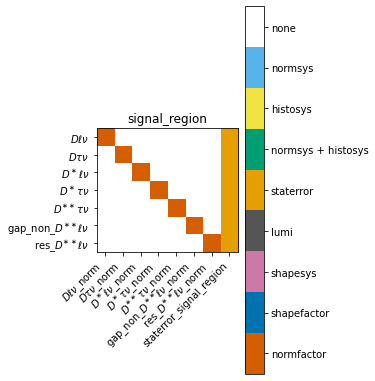

In [9]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [10]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier gap_non_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (702 new nuisance parameters)


In [3]:
model, data = cabinetry.model_utils.model_and_data(spec)

DEBUG - cabinetry.model_utils - total stdev is [[1.17, 1.5, 1.64, 1.5, 2.01, 1.77, ..., 0.959, 1.48, 3.77, 5.77, 5.89, 4.17]]
DEBUG - cabinetry.model_utils - total stdev per channel is [238]
INFO - cabinetry.visualize.utils - saving figure as figures/electron_prefit.pdf


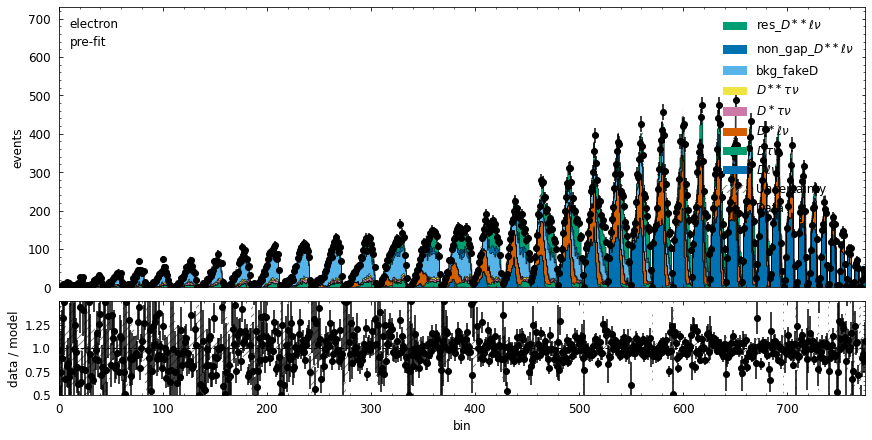

In [29]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

# 3. MLE

In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

In [12]:
%%time
## after changing the fitting region and remove fakeD
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2527                       │      Nfcn = 191883, Ngrad = 10       │
│ EDM = 0.000432 (Goal: 0.0002)    │           time = 67.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

INFO - cabinetry.fit - staterror_signal_region[81]        =  1.0530 +/- 0.1935
INFO - cabinetry.fit - staterror_signal_region[82]        =  1.2757 +/- 0.2031
INFO - cabinetry.fit - staterror_signal_region[83]        =  1.0026 +/- 0.1392
INFO - cabinetry.fit - staterror_signal_region[84]        =  0.9864 +/- 0.1270
INFO - cabinetry.fit - staterror_signal_region[85]        =  0.9794 +/- 0.1268
INFO - cabinetry.fit - staterror_signal_region[86]        =  0.9436 +/- 0.1139
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.8906 +/- 0.1070
INFO - cabinetry.fit - staterror_signal_region[88]        =  1.0574 +/- 0.1287
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.6960 +/- 0.1385
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.1605 +/- 0.2290
INFO - cabinetry.fit - staterror_signal_region[91]        =  0.7079 +/- 0.4077
INFO - cabinetry.fit - staterror_signal_region[92]        =  0.7753 +/- 0.3268
INFO - cabinetry.fit - staterror_signal_region[93]  

INFO - cabinetry.fit - staterror_signal_region[185]       =  0.8658 +/- 0.1109
INFO - cabinetry.fit - staterror_signal_region[186]       =  0.9027 +/- 0.1008
INFO - cabinetry.fit - staterror_signal_region[187]       =  0.9497 +/- 0.0946
INFO - cabinetry.fit - staterror_signal_region[188]       =  0.9737 +/- 0.0877
INFO - cabinetry.fit - staterror_signal_region[189]       =  0.9926 +/- 0.0734
INFO - cabinetry.fit - staterror_signal_region[190]       =  1.0164 +/- 0.0727
INFO - cabinetry.fit - staterror_signal_region[191]       =  0.9443 +/- 0.0726
INFO - cabinetry.fit - staterror_signal_region[192]       =  0.9848 +/- 0.0725
INFO - cabinetry.fit - staterror_signal_region[193]       =  1.0305 +/- 0.0691
INFO - cabinetry.fit - staterror_signal_region[194]       =  0.9507 +/- 0.0688
INFO - cabinetry.fit - staterror_signal_region[195]       =  0.9523 +/- 0.0748
INFO - cabinetry.fit - staterror_signal_region[196]       =  0.9805 +/- 0.0778
INFO - cabinetry.fit - staterror_signal_region[197] 

INFO - cabinetry.fit - staterror_signal_region[289]       =  0.9272 +/- 0.0604
INFO - cabinetry.fit - staterror_signal_region[290]       =  1.0196 +/- 0.0684
INFO - cabinetry.fit - staterror_signal_region[291]       =  0.9931 +/- 0.0891
INFO - cabinetry.fit - staterror_signal_region[292]       =  1.3043 +/- 0.2851
INFO - cabinetry.fit - staterror_signal_region[293]       =  0.3293 +/- 0.6885
INFO - cabinetry.fit - staterror_signal_region[294]       =  1.4738 +/- 0.4336
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0845 +/- 0.2314
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0060 +/- 0.1546
INFO - cabinetry.fit - staterror_signal_region[297]       =  0.8972 +/- 0.1118
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.8851 +/- 0.0717
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0123 +/- 0.0609
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0542 +/- 0.0542
INFO - cabinetry.fit - staterror_signal_region[301] 

INFO - cabinetry.fit - staterror_signal_region[393]       =  0.9868 +/- 0.0318
INFO - cabinetry.fit - staterror_signal_region[394]       =  1.0143 +/- 0.0294
INFO - cabinetry.fit - staterror_signal_region[395]       =  0.9988 +/- 0.0290
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0213 +/- 0.0330
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0050 +/- 0.0396
INFO - cabinetry.fit - staterror_signal_region[398]       =  0.9857 +/- 0.0387
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0971 +/- 0.0471
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0387 +/- 0.0511
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9396 +/- 0.0507
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0796 +/- 0.0695
INFO - cabinetry.fit - staterror_signal_region[403]       =  0.7216 +/- 0.1109
INFO - cabinetry.fit - staterror_signal_region[404]       =  0.7648 +/- 0.3250
INFO - cabinetry.fit - staterror_signal_region[405] 

INFO - cabinetry.fit - staterror_signal_region[497]       =  1.2263 +/- 0.2401
INFO - cabinetry.fit - staterror_signal_region[498]       =  1.1904 +/- 0.1191
INFO - cabinetry.fit - staterror_signal_region[499]       =  1.0259 +/- 0.0503
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9681 +/- 0.0384
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.0031 +/- 0.0372
INFO - cabinetry.fit - staterror_signal_region[502]       =  0.9394 +/- 0.0317
INFO - cabinetry.fit - staterror_signal_region[503]       =  0.9790 +/- 0.0291
INFO - cabinetry.fit - staterror_signal_region[504]       =  0.9990 +/- 0.0275
INFO - cabinetry.fit - staterror_signal_region[505]       =  0.9769 +/- 0.0271
INFO - cabinetry.fit - staterror_signal_region[506]       =  0.9682 +/- 0.0354
INFO - cabinetry.fit - staterror_signal_region[507]       =  0.9889 +/- 0.0435
INFO - cabinetry.fit - staterror_signal_region[508]       =  0.9893 +/- 0.0653
INFO - cabinetry.fit - staterror_signal_region[509] 

INFO - cabinetry.fit - staterror_signal_region[601]       =  0.6914 +/- 0.4035
INFO - cabinetry.fit - staterror_signal_region[602]       =  0.9414 +/- 0.0959
INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9393 +/- 0.0721
INFO - cabinetry.fit - staterror_signal_region[604]       =  0.9860 +/- 0.0940


CPU times: user 2min 7s, sys: 872 ms, total: 2min 8s
Wall time: 2min 16s


In [11]:
%%time
## after changing the fitting region and remove fakeD
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2597                       │            Nfcn = 255218             │
│ EDM = 3.06e-09 (Goal: 0.0002)    │           time = 120.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 2597.396556 at

INFO - cabinetry.fit - staterror_signal_region[83]        =  1.0000 +/- 0.4083
INFO - cabinetry.fit - staterror_signal_region[84]        =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_signal_region[85]        =  1.0000 +/- 0.3545
INFO - cabinetry.fit - staterror_signal_region[86]        =  1.0000 +/- 0.2362
INFO - cabinetry.fit - staterror_signal_region[87]        =  1.0000 +/- 0.2894
INFO - cabinetry.fit - staterror_signal_region[88]        =  1.0000 +/- 0.2144
INFO - cabinetry.fit - staterror_signal_region[89]        =  1.0000 +/- 0.2372
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.0000 +/- 0.1547
INFO - cabinetry.fit - staterror_signal_region[91]        =  1.0000 +/- 0.1420
INFO - cabinetry.fit - staterror_signal_region[92]        =  1.0000 +/- 0.1586
INFO - cabinetry.fit - staterror_signal_region[93]        =  1.0000 +/- 0.0963
INFO - cabinetry.fit - staterror_signal_region[94]        =  1.0000 +/- 0.0925
INFO - cabinetry.fit - staterror_signal_region[95]  

INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0000 +/- 0.1454
INFO - cabinetry.fit - staterror_signal_region[188]       =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0000 +/- 0.4978
INFO - cabinetry.fit - staterror_signal_region[190]       =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.0000 +/- 0.2355
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0000 +/- 0.1768
INFO - cabinetry.fit - staterror_signal_region[193]       =  1.0000 +/- 0.1445
INFO - cabinetry.fit - staterror_signal_region[194]       =  1.0000 +/- 0.1363
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0000 +/- 0.1235
INFO - cabinetry.fit - staterror_signal_region[196]       =  1.0000 +/- 0.1396
INFO - cabinetry.fit - staterror_signal_region[197]       =  1.0000 +/- 0.1296
INFO - cabinetry.fit - staterror_signal_region[198]       =  1.0000 +/- 0.1126
INFO - cabinetry.fit - staterror_signal_region[199] 

INFO - cabinetry.fit - staterror_signal_region[291]       =  1.0000 +/- 0.0830
INFO - cabinetry.fit - staterror_signal_region[292]       =  1.0000 +/- 0.0672
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.0000 +/- 0.0593
INFO - cabinetry.fit - staterror_signal_region[294]       =  1.0000 +/- 0.0487
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0000 +/- 0.0447
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0000 +/- 0.0381
INFO - cabinetry.fit - staterror_signal_region[297]       =  1.0000 +/- 0.0407
INFO - cabinetry.fit - staterror_signal_region[298]       =  1.0000 +/- 0.0385
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0000 +/- 0.0392
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0000 +/- 0.0390
INFO - cabinetry.fit - staterror_signal_region[301]       =  1.0000 +/- 0.0413
INFO - cabinetry.fit - staterror_signal_region[302]       =  1.0000 +/- 0.0419
INFO - cabinetry.fit - staterror_signal_region[303] 

INFO - cabinetry.fit - staterror_signal_region[395]       =  1.0000 +/- 0.0273
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0000 +/- 0.0262
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0000 +/- 0.0236
INFO - cabinetry.fit - staterror_signal_region[398]       =  1.0000 +/- 0.0226
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.0000 +/- 0.0245
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0000 +/- 0.0272
INFO - cabinetry.fit - staterror_signal_region[401]       =  1.0000 +/- 0.0297
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0000 +/- 0.0322
INFO - cabinetry.fit - staterror_signal_region[403]       =  1.0000 +/- 0.0328
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0000 +/- 0.0362
INFO - cabinetry.fit - staterror_signal_region[405]       =  1.0000 +/- 0.0375
INFO - cabinetry.fit - staterror_signal_region[406]       =  1.0000 +/- 0.0416
INFO - cabinetry.fit - staterror_signal_region[407] 

INFO - cabinetry.fit - staterror_signal_region[499]       =  1.0000 +/- 0.0454
INFO - cabinetry.fit - staterror_signal_region[500]       =  1.0000 +/- 0.0835
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.0000 +/- 0.4070
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.0000 +/- 0.3528
INFO - cabinetry.fit - staterror_signal_region[503]       =  1.0000 +/- 0.3157
INFO - cabinetry.fit - staterror_signal_region[504]       =  1.0000 +/- 0.3157
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0000 +/- 0.2498
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0000 +/- 0.2040
INFO - cabinetry.fit - staterror_signal_region[507]       =  1.0000 +/- 0.1054
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.0000 +/- 0.0459
INFO - cabinetry.fit - staterror_signal_region[509]       =  1.0000 +/- 0.0327
INFO - cabinetry.fit - staterror_signal_region[510]       =  1.0000 +/- 0.0296
INFO - cabinetry.fit - staterror_signal_region[511] 

INFO - cabinetry.fit - staterror_signal_region[603]       =  1.0000 +/- 0.0461
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.0000 +/- 0.0304
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0000 +/- 0.0275
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.0000 +/- 0.0233
INFO - cabinetry.fit - staterror_signal_region[607]       =  1.0000 +/- 0.0213
INFO - cabinetry.fit - staterror_signal_region[608]       =  1.0000 +/- 0.0209
INFO - cabinetry.fit - staterror_signal_region[609]       =  1.0000 +/- 0.0228
INFO - cabinetry.fit - staterror_signal_region[610]       =  1.0000 +/- 0.0349
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.0000 +/- 0.0751
INFO - cabinetry.fit - staterror_signal_region[612]       =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_signal_region[613]       =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_signal_region[614]       =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_signal_region[615] 

CPU times: user 3min 34s, sys: 4.28 s, total: 3min 39s
Wall time: 3min 25s


In [ ]:
%%time
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
fit_results = cabinetry.fit.fit(model=model, data=data,init_pars=list(parameters),)
                                #minos=model.config.parameters[:7])

In [ ]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


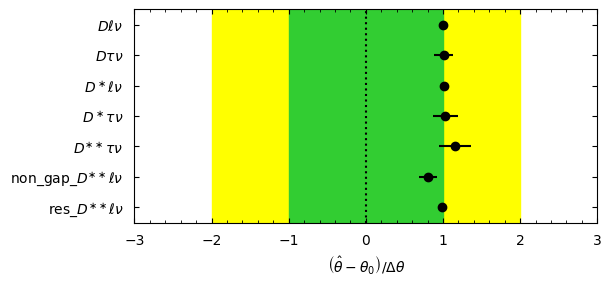

In [12]:
# gap * 0.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


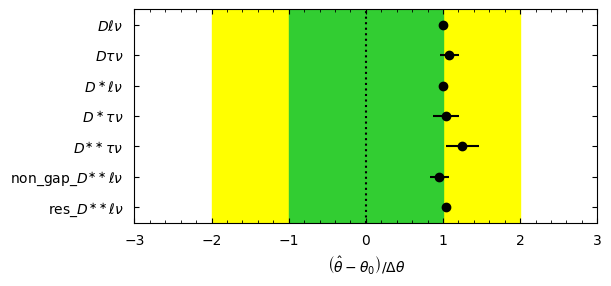

In [19]:
# gap * 1.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


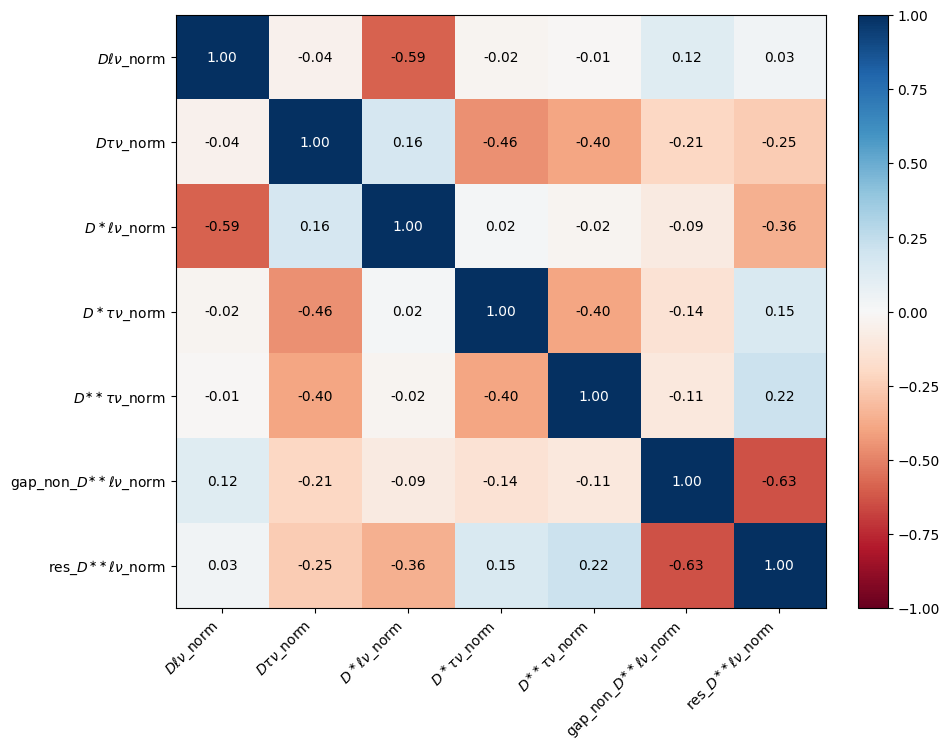

In [12]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.3)

In [31]:
# model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
templates = np.array([s['data'] for s in electron_channel['samples']])
counts=np.sum(test0,axis=0).reshape(41,47)

start = 0.8
end = 4.2
num_bins = 40
yedges = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50
xedges = np.linspace(start, end, num_bins + 1)

templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,1.5],direction='p_D_l',plot_with='pltbar')

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,2.5],direction='mm2',plot_with='pltbar')

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [5]:
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
poi = model.config.parameters[:6]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pyhf.set_backend("numpy", 'minuit')

# init the norm parameters
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
poi = model.config.parameters[:6] # same as model.config.par_order

In [5]:
from multiprocessing import Pool

def fit_toys(toy):
    try:
        return cabinetry.fit.fit(model=model, data=toy)
        # return pyhf.infer.mle.fit(toy, model,return_uncertainties=True)
    except pyhf.exceptions.FailedMinimization:
        pass

def generate_toys(init_norm=None, n_toys=100, poi=poi,seed=0):
    # initialize the generator and model
    toy_pars = model.config.suggested_init()
    rng = np.random.default_rng(seed)
    toy_pars[:len(poi)] = rng.random(len(poi))
    if type(init_norm) in [int, float]:
        toy_pars[:len(poi)] = [init_norm]*len(poi)
    # print(f"init parameters: {list(zip(model.config.parameters, [round(n,2) for n in toy_pars]))}")

    # make the pdfs
    pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

    # draws samples from the pdf shape given the number of samples N=(10000,)
    return pdf_toy.sample((n_toys,)), toy_pars

def pull_plot(init_norm=None, n_toys=100, poi=poi):
    # create toys
    toys, toy_pars = generate_toys(init_norm=init_norm, n_toys=n_toys)
    
    # fit toys
    with Pool(None, maxtasksperchild=1) as p:
        fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))
    
    bestfit = np.array([f.bestfit for f in fit_results])
    errors = np.array([f.uncertainty for f in fit_results])
    
    # calculate pulls
    pulls = np.array(
        [
                (bestfit[:,model.config.par_slice(k)] - toy_pars[model.config.par_slice(k)])
                / errors[:,model.config.par_slice(k)]
            for k in model.config.par_order[:len(poi)]
        ]
    )
    
    # plot pulls
    bins = np.linspace(-5,5,50)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.hist(pulls[i], bins=bins)
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.axvline(0, label="expected", color="black", linestyle="dashed")
        ax.axvline(np.mean(pulls[i]), label="empirical mean", color="red", linestyle="dashed")
        ax.legend(title=f'$\sigma$ = {np.std(pulls[i]):.2f}')
        ax.grid()
               
    fig.suptitle(f'{len(fit_results)} successful toy fits pull plot',fontsize=16)
    fig.supylabel('# of toys per bin',x=0.06,fontsize=16)
    fig.supxlabel(r'Pulls = $(\mu - \hat{\mu})\,/ \delta \mu$', y=0.06,fontsize=16)
    
def linearity_plot(n_tests, n_toys, poi=poi):
    truth_all = np.empty((n_tests, len(poi)))
    fitted_all = np.empty((n_tests, len(poi)))
    errors_all = np.empty((n_tests, len(poi)))
    for i in range(n_tests):
        # initialize toys
        toys, toy_pars = generate_toys(n_toys=n_toys, seed=i)
        
        # fit toys
        with Pool(None, maxtasksperchild=10) as p:
            fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))

        bestfit = np.array([f.bestfit for f in fit_results])
        
        # save fitted parameters
        mean = np.mean(bestfit[:,:len(poi)], axis=1)
        std = np.std(bestfit[:,:len(poi)], axis=1)
        
        truth_all[i] = toy_pars[:len(poi)]
        fitted_all[i] = mean
        errors_all[i] = std
        
    # plot linearity
    bins = np.linspace(0,1,10)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.errorbar(x=truth_all[:,i], y=fitted_all[:,i], yerr=errors_all[:,i], fmt='ko')
        ax.plot(bins,bins,label="expected", color="red", linestyle="dashed")
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.legend()
        ax.grid()

    fig.suptitle(f'{n_tests} Test points with {n_toys} toys for each point',fontsize=16)
    fig.supylabel('Fitted',x=0.06,fontsize=16)
    fig.supxlabel('Truth', y=0.06,fontsize=16)

In [9]:
a=[1,2,3]
def square(x):
    return x**2
if __name__ == '__main__':
    with Pool(None, maxtasksperchild=1) as p:
        r = np.array(list(tqdm(p.imap(square, a), total=len(a),desc =f"Fitting toys")))
    print(r)

Fitting toys:   0%|          | 0/3 [00:00<?, ?it/s]

[1 4 9]


In [ ]:
pull_plot(init_norm=1, n_toys=50)

Fitting toys:   0%|          | 0/50 [00:00<?, ?it/s]

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.168366 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000859329
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00199864
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0115167
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.033026
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0137391
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00364929
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.0537739
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -0.0211273
W MnPosDef non-positive diagonal element in covariance matrix[ 17 ] = -0.000115004
W MnPosDef non-positive diagonal element in covariance matrix[ 55 ] = -0.0209275
W MnPosDef non-positive diagonal element in cov

Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-51:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-73:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-74:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/m

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    r

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/ext

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 1

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
Traceback (most recent call last):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/li

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 115, in _minimize
    minimizer.migrad(ncall=maxiter)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/e

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 702, in migrad
    fm = migrad(ncall, self._tolerance)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/o

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zh

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 19

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-pac

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 945, in logpdf
    result = self.make_pdf(pars).log_prob(data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, 

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in log_prob
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 186, in log_prob
    result = super().log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-package

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 254, in sum
    return np.sum(tensor_in, axis=axis)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/modifiers/normfactor.py", line 113, in apply
    results_normfactor = tensorlib.where(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in <listcomp>
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3076, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 355, in where
    return np.where(mask, tensor_in_1, tensor_in_2)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "<__array_function__ internals>", line 200, in where
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2324, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 439, in poisson_

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 490, in normal_logpdf
    root2pi = np.sqrt(2 * np.pi)
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 70, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 436, in einsum
    return np.einsum(subscripts, *operands)  # type: ignore[arg-type,no-any-return]
  File "<__array_function__ internals>", line 200, in prod
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 50, in log_prob
    return tensorlib.normal_logpdf(value, self.loc, self.scale)
  File "<__array_function__ internals>", line 200, in einsum
KeyboardInterrupt
  File "<__array_function__ internals>", line 200, in einsum
  File "<__array_function__ internals>", line 200, in where
KeyboardInterrupt
  File

In [7]:
linearity_plot(n_tests=40, n_toys=50, poi=poi)

Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-80:
Process ForkPoolWorker-65:
Process ForkPoolWorker-73:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-63:
Process ForkPoolWorker-79:
Process ForkPoolWorker-61:
Process ForkPoolWorker-77:
Process ForkPoolWorker-55:
Process ForkPoolWorker-68:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-69:
Process ForkPoolWorker-58:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-74:
Process ForkPoolWorker-66:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-62:
Process ForkPoolWorker-71:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pr

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/sy

KeyboardInterrupt: 